In [1]:
import numpy as np
import pandas as pd
import sys
import os 
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import glob

import sys
print(sys.path)

from sglm import utils, glm_fit

#d1 - T430
#d2 - T434

['c:\\Users\\Livia\\Desktop\\photometry_liv\\photometry_preprocessing\\sabatini-glm-workflow\\notebooks', 'c:\\Users\\Livia\\.conda\\envs\\glm\\python311.zip', 'c:\\Users\\Livia\\.conda\\envs\\glm\\DLLs', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib', 'c:\\Users\\Livia\\.conda\\envs\\glm', '', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages\\win32', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages\\Pythonwin']


## Create a project

#### First, let's create a new project. The project directory will create a data and results folder and a config file.

#### You will need to edit the config file with the particular glm params you wish to use. Fields that are necessary to edit are: predictors, predictors_shift_bounds, response, and the glm_keyword_args.

#### You will also need to move your data into the data folder.

In [2]:
project_name = 'T434_h2Hist_glm' #'D1_h3Hist_all_glm' 
project_dir = r'\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output' # windows
# project_dir = r'/Volumes/Neurobio/MICROSCOPE/Livia/glm_output' # mac

utils.create_new_project(project_name, project_dir)

Project directory already exists!


'\\\\research.files.med.harvard.edu\\\\Neurobio\\\\MICROSCOPE\\\\Livia\\\\glm_output\\T434_h2Hist_glm\\config.yaml'

# Import and Format Data

Input data should conform to the following convention and be saved as a *.csv:

Indices / Unique Row Identifiers:
* SessionName -- Any order is acceptable
* TrialNumber-- Must be in chronological order, but does not need to start from zero
* Timestamp -- Must be in chronological order, but does not need to start from zero

Columns (Predictors + Responses):
* Predictors - binary
* Reponses - e.g. neural responses (analog or binary)

Example, shown below is dummy data depicting a trial_0 that last four response timestamps:
| SessionName | TrialNumber | Timestamp | predictor_1 | predictor_2 | predictor_3 | response_1 | response_2 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| session_0 | trial_0 | -1 | 0 | 0 | 0 | 1 | 0.3 |
| session_0 | trial_0 | 0 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_0 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_0 | 2 | 0 | 1 | 0 | 1 | 0.3 |
| session_0 | trial_1 | -2 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | -1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_1 | 0 | 1 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 5 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 6 | 1 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 7 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 8 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_1 | 9 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_1 | 10 | 0 | 0 | 0 | 1 | 2.3 |
....

#### Now, let's get set up to start our project

In [3]:
project_path = os.path.join(project_dir, project_name)
files = os.listdir(project_path)

assert 'data' in files, 'data folder not found! {}'.format(files)
assert 'results' in files, 'results folder not found! {}'.format(files)
assert 'config.yaml' in files, 'config.yaml not found! {}'.format(files)

#### If needed, use the following function to combine multiple sessions into one csv. You will need a filename you wish to call your output_csv

In [4]:
left = False
if left:
    # output_csv = 'output.csv'
    p_split = project_name.split("_")
    p_name = p_split[0][:len(p_split[0])-1]
    name = p_name +"_"+ p_split[1]
    print(name)
    output_csv = name +'Format.csv'
else: output_csv = project_name +'Format.csv'

output_csv
# utils.combine_csvs(project_path, output_csv)

'T434_h2Hist_glmFormat.csv'

#### Next, we'll open the data and set the columns you wish to use as fixed indices

In [5]:
input_file = os.path.join(project_path, 'data', output_csv)
index_col = ['SessionName', 'TrialNumber', 'Timestamp']

df = utils.read_data(input_file, index_col)

print('Your dataframe has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
df

Your dataframe has 368370 rows and 28 columns


AA_cue  Aa_cue  aa_cue  aB_cue  \
SessionName     TrialNumber Timestamp                                     
T434_2023_08_15 3039.0      260.439245      0.0     0.0     0.0     0.0   
                            260.459889      0.0     0.0     0.0     0.0   
                            260.480532      0.0     0.0     0.0     0.0   
                            260.501176      0.0     0.0     0.0     0.0   
                            260.521820      0.0     0.0     0.0     0.0   
...                                         ...     ...     ...     ...   
T434_2023_08_11 3037.0      1481.212723     0.0     0.0     0.0     0.0   
                            1481.233367     0.0     0.0     0.0     0.0   
                            1481.254011     0.0     0.0     0.0     0.0   
                            1481.274655     0.0     0.0     0.0     0.0   
                            1481.295299     0.0     0.0     0.0     0.0   

                                         Ab_cue  AB_cue  Select_L  Select_R  \
SessionName     TrialNumber Timestamp                                         
T434_2023_08_15 3039.0      260.439245      0.0     0.0         0         0   
                            260.459889      0.0     0.0         0         0   
                            260.480532      0.0     0.0         0         0   
                            260.501176      0.0     0.0         0         0   
                            260.521820      0.0     0.0         0         0   
...                                         ...     ...       ...       ...   
T434_2023_08_11 3037.0      1481.212723     0.0     0.0         0         0   
                            1481.233367     0.0     0.0         0         0   
                            1481.254011     0.0     0.0         0         0   
                            1481.274655     0.0     0.0         0         0   
                            1481.295299     0.0     0.0         0         0   

                                         enl200  enl400  ...  Consumption_R_R  \
SessionName     TrialNumber Timestamp                    ...                    
T434_2023_08_15 3039.0      260.439245      1.0     0.0  ...              0.0   
                            260.459889      0.0     0.0  ...              0.0   
                            260.480532      0.0     0.0  ...              0.0   
                            260.501176      0.0     0.0  ...              0.0   
                            260.521820      0.0     0.0  ...              0.0   
...                                         ...     ...  ...              ...   
T434_2023_08_11 3037.0      1481.212723     0.0     0.0  ...              0.0   
                            1481.233367     0.0     0.0  ...              0.0   
                            1481.254011     0.0     0.0  ...              0.0   
                            1481.274655     0.0     0.0  ...              0.0   
                            1481.295299     0.0     0.0  ...              0.0   

                                         Consumption_R_L  Consumption_UR_R  \
SessionName     TrialNumber Timestamp                                        
T434_2023_08_15 3039.0      260.439245               0.0               0.0   
                            260.459889               0.0               0.0   
                            260.480532               0.0               0.0   
                            260.501176               0.0               0.0   
                            260.521820               0.0               0.0   
...                                                  ...               ...   
T434_2023_08_11 3037.0      1481.212723              0.0               0.0   
                            1481.233367              0.0               0.0   
                            1481.254011              0.0               0.0   
                            1481.274655              0.0               0.0   
                            1481.295299        

#### You can now explore and add to the dataframe. As an example, you may want to add various "predictors" or "features" to explore. You can use the example below as inspiration

In [6]:
# #Identify the individual licks that have specific meaning in the tasks: 
# #lick 1, lick 2 and lick 3 are "operant licks" on different training days
# #licknon1-3 are all the other licks

# df_source = df.copy()
# srs_lick = df_source.groupby(['SessionName', 'TrialNumber'])['Lick'].cumsum()
# srs_lick_count = srs_lick * df_source['Lick']
# df_lick_count_dummies = pd.get_dummies(srs_lick_count).drop(0, axis=1)
# df_lick_count_dummies = df_lick_count_dummies[[1,2,3]]
# df_lick_count_dummies['non1-3'] = df_source['Lick'] - df_lick_count_dummies.sum(axis=1)
# df_lick_count_dummies.columns = [f'lick_{original_column_name}' for original_column_name in df_lick_count_dummies.columns]

# # Columns lick and lick_1, lick_2, lick_3, lick_non-13 should not all be used together
# # as predictors because of multicollinearity.
# df_source = pd.concat([df_source, df_lick_count_dummies], axis=1)
# df_source

# assert np.all(df_source['Lick'] == df_source[['lick_1', 'lick_2', 'lick_3', 'lick_non1-3']].sum(axis=1)), 'Column lick should equal the sum of all other lick columns.'

#### Friendly reminder, the df we have imported is mutli-index, meaning, it's organization is dependent on 3-columns that we have set in index_col. Therefore, we can use "groupby" if you need to split the organization. 

In [7]:
# reIndex = df_source.groupby(level=[0, 1])

## Load your fitting paramaters and set up your train/test data

In [8]:
config_file = os.path.join(project_path, 'config.yaml')
config = utils.load_config(config_file)
config

{'Project': {'project_name': 'T434_hist2_glm',
  'project_path': '/Volumes/Neurobio/MICROSCOPE/Livia/glm_output/T434_hist2_glm'},
 'glm_params': {'glm_keyword_args': {'alpha': 0.0025,
   'fit_intercept': True,
   'l1_ratio': 0.00025,
   'max_iter': 1000,
   'n_alphas': 100,
   'n_jobs': -1,
   'score_metric': 'r2',
   'selection': 'cyclic',
   'warm_start': False},
  'predictors': ['aB_cue',
   'AA_cue',
   'Ab_cue',
   'aa_cue',
   'Aa_cue',
   'AB_cue',
   'Select_R',
   'Select_L',
   'enl200',
   'enl400',
   'enl600',
   'enl800',
   'enl1000',
   'enl1200',
   'enl1400',
   'enl1600',
   'enl1800',
   'enl2000',
   'Consumption_R_R',
   'Consumption_UR_R',
   'Consumption_R_L',
   'Consumption_UR_L',
   'Cons_more_R_R',
   'Cons_more_R_L',
   'Cons_more_UR_R',
   'Cons_more_UR_L'],
  'predictors_shift_bounds': {'aB_cue': [-75, 75],
   'AA_cue': [-75, 75],
   'Ab_cue': [-75, 75],
   'aa_cue': [-75, 75],
   'Aa_cue': [-75, 75],
   'AB_cue': [-75, 75],
   'Select_R': [-75, 75],
   '

#### Shift responses and predictors. If you do not want to shift your predictors by an amount you set, feel free to comment out the entire "predictors_shift_bounds" in config.yaml. We will then use the default set when we created the config file.

In [9]:
for col in df.columns:
    print(col, df[col].unique())

AA_cue [0. 1.]
Aa_cue [0. 1.]
aa_cue [0. 1.]
aB_cue [0. 1.]
Ab_cue [0. 1.]
AB_cue [0. 1.]
Select_L [0 1]
Select_R [0 1]
enl200 [1. 0.]
enl400 [0. 1.]
enl600 [0. 1.]
enl800 [0. 1.]
enl1000 [0. 1.]
enl1200 [0. 1.]
enl1400 [0. 1.]
enl1600 [0. 1.]
enl1800 [0. 1.]
enl2000 [0. 1.]
Consumption_R_R [0. 1.]
Consumption_R_L [0. 1.]
Consumption_UR_R [0. 1.]
Consumption_UR_L [0. 1.]
Cons_more_R_R [0. 1.]
Cons_more_R_L [0. 1.]
Cons_more_UR_R [0. 1.]
Cons_more_UR_L [0. 1.]
z_grnR [0.29935199 0.27212354 0.23713982 ... 0.8719959  0.90170513 0.91588053]
z_grnL [-0.12140082 -0.13835717 -0.15464707 ...  0.04099072  0.0437526
  0.04232599]


In [10]:
df.shape

(368370, 28)

In [11]:
response_shift, df_predictors_shift, shifted_params = glm_fit.shift_predictors(config, df)
print('Your dataframe was shifted using: {}'.format(shifted_params))

df_predictors_shift.shape


Your dataframe was shifted using: [('aB_cue', [-75, 75]), ('AA_cue', [-75, 75]), ('Ab_cue', [-75, 75]), ('aa_cue', [-75, 75]), ('Aa_cue', [-75, 75]), ('AB_cue', [-75, 75]), ('Select_R', [-75, 75]), ('Select_L', [-75, 75]), ('enl200', [0, 10]), ('enl400', [0, 10]), ('enl600', [0, 10]), ('enl800', [0, 10]), ('enl1000', [0, 10]), ('enl1200', [0, 10]), ('enl1400', [0, 10]), ('enl1600', [0, 10]), ('enl1800', [0, 10]), ('enl2000', [0, 10]), ('Consumption_R_R', [-75, 75]), ('Consumption_UR_R', [-75, 75]), ('Consumption_R_L', [-75, 75]), ('Consumption_UR_L', [-75, 75]), ('Cons_more_R_R', [-75, 75]), ('Cons_more_R_L', [-75, 75]), ('Cons_more_UR_R', [-75, 75]), ('Cons_more_UR_L', [-75, 75])]


(346930, 2526)

In [12]:
df_predictors_shift

aB_cue                                \
                                           -75  -74  -73  -72  -71  -70  -69   
SessionName     TrialNumber Timestamp                                          
T434_2023_08_15 3039.0      261.987533     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.008177     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.028820     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.049464     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.070108     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                        ...  ...  ...  ...  ...  ...  ...   
T434_2023_08_11 3037.0      1479.664435    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.685079    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.705723    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.726367    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.747011    0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                        ... Cons_more_UR_L  \
                                         -68  -67  -66  ...             66   
SessionName     TrialNumber Timestamp                   ...                  
T434_2023_08_15 3039.0      261.987533   0.0  0.0  0.0  ...            0.0   
                            262.008177   0.0  0.0  0.0  ...            0.0   
                            262.028820   0.0  0.0  0.0  ...            0.0   
                            262.049464   0.0  0.0  0.0  ...            0.0   
                            262.070108   0.0  0.0  0.0  ...            0.0   
...                                      ...  ...  ...  ...            ...   
T434_2023_08_11 3037.0      1479.664435  0.0  0.0  0.0  ...            0.0   
                            1479.685079  0.0  0.0  0.0  ...            0.0   
                            1479.705723  0.0  0.0  0.0  ...            0.0   
                            1479.726367  0.0  0.0  0.0  ...            0.0   
                            1479.747011  0.0  0.0  0.0  ...            0.0   

                                                                            \
                                          67   68   69   70   71   72   73   
SessionName     TrialNumber Timestamp                                        
T434_2023_08_15 3039.0      261.987533   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.008177   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.028820   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.049464   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            262.070108   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                      ...  ...  ...  ...  ...  ...  ...   
T434_2023_08_11 3037.0      1479.664435  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.685079  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.705723  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.726367  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1479.747011  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                   
                                          74   75  
SessionName     TrialNumber Timestamp              
T434_2023_08_15 3039.0      261.987533   0.0  0.0  
                            262.008177   0.0  0.0  
                            262.028820   0.0  0.0  
                            262.049464   0.0  0.0  
                            262.070108   0.0  0.0  
...                                      ...  ...  
T434_2023_08_11 3037.0      1479.664435  0.0  0.0  
                            1479.685079  0.0  0.0  
                            1479.705723  0.0  0.0  
                            1479.726367  0.0  0.0  
                            1479.747011  0.0  0.0  

[346

In [13]:
enl_columns = df_predictors_shift.filter(like='enl', axis=1)
session = 'T430_2023_08_14'
filt_ind = [ind for ind, col in enumerate(enl_columns.index) if session in col]

rows_taken = [col for col in enl_columns.index if session in col]
print(F"{session} rows num: {len(rows_taken)}")

combined_all = enl_columns.iloc[filt_ind].sum(axis=1)
for com in combined_all.unique():
    print(f"{com} number: {len(np.where(combined_all == com)[0])}")
combined_all


T430_2023_08_14 rows num: 0


Series([], dtype: float64)

In [14]:
print(f"{0} number: {np.where(combined_all == 0)[0]}")

test = enl_columns.iloc[80:100]
test


0 number: []


enl200                                \
                                            0    1    2    3    4    5    6   
SessionName     TrialNumber Timestamp                                         
T434_2023_08_15 3039.0      263.639040    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.659684    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.680328    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.700972    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.721615    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.742259    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.762903    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.783547    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.804191    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.824835    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.845478    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.866122    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.886766    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.907410    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.928054    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.948698    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.969341    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            263.989985    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            264.010629    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            264.031273    0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                       ... enl2000            \
                                          7    8    9  ...       1    2    3   
SessionName     TrialNumber Timestamp                  ...                     
T434_2023_08_15 3039.0      263.639040  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.659684  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.680328  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.700972  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.721615  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.742259  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.762903  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.783547  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.804191  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.824835  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.845478  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.866122  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.886766  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.907410  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.928054  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.948698  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.969341  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            263.989985  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            264.010629  0.0  0.0  0.0  ...     0.0  0.0  0.0   
                            264.031273  0.0  0.0  0.0  ...     0.0  0.0  0.0   

                                                                           
                                          4    5    6    7    8    9   10  
SessionName     TrialNumber Timestamp                                      
T434_2023_08_15 3039.0      263.639040  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                            263.659684  0.0  0.0  0.0  0.0  0.0  0.0  0.0  


In [15]:
#create sparse array - by row
import scipy
sparse_df = scipy.sparse.csr_array(df_predictors_shift)

In [16]:
sparse_df

<346930x2526 sparse array of type '<class 'numpy.float64'>'
	with 3242262 stored elements in Compressed Sparse Row format>

In [17]:
response_shift 
temp = response_shift.values.flatten()

### Create your test/train datasets

In [39]:
## X_train,X_test, y_train, y_test = glm_fit.split_data(df_predictors_shift, temp, config) 
# X_train,X_test, y_train, y_test = glm_fit.split_data(sparse_df, temp, config) 

# import trial_split

def hist(set):
    import numpy as np
    import matplotlib.pyplot as plt

    # Create a histogram
    plt.hist(set, bins=len(np.unique(set)), color='blue', alpha=0.7)

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    # Show the plot
    plt.show()
    
# def renumber_trials(trials):
    
#     unique_values, unique_ind, unique_count = np.unique(trials[:, 1], return_index=True, return_counts=True)
#     found = []
#     for ind in unique_ind:
#         if trials[:, 1][ind] not in found:
#             found.append(trials[:, 1][ind])
#         else:
#             print("found twice")
        
            
#     print(found)


# test = (np.vstack(([1, 2, 2, 3, 4, 4, 1], [1, 1, 2, 2, 3, 4, 1]))).transpose()
# print(test)
# tester = renumber_trials(test)

import numpy as np

def renumber_trials(trials):
    unique_values, unique_ind, unique_count = np.unique(trials[:, 1], return_index=True, return_counts=True)
    found = []
    for i in range(0, len(trials)):
        val_ind = (np.where(trials[:, 1] == trials[:, 1][i]))[0]
        print(f"val_ind: {val_ind}")
        
        if trials[:, 1][i] in found:
            print("found twice")
        else:
            found.append(trials[:, 1][i])

    print(found)

test = np.vstack(([1, 2, 2, 3, 4, 4, 1], [1, 1, 2, 2, 3, 4, 1])).transpose()
print(test)
renumber_trials(test)


[[1 1]
 [2 1]
 [2 2]
 [3 2]
 [4 3]
 [4 4]
 [1 1]]
val_ind: [0 1 6]
val_ind: [0 1 6]
found twice
val_ind: [2 3]
val_ind: [2 3]
found twice
val_ind: [4]
val_ind: [5]
val_ind: [0 1 6]
found twice
[1, 2, 3, 4]


[2132.0, 2133.0, 2134.0, 2137.0, 2138.0, 2140.0, 2141.0, 2144.0, 2145.0, 2147.0, 2148.0, 2149.0, 2150.0, 2151.0, 2152.0, 2154.0, 2157.0, 2158.0, 2160.0, 2161.0, 2162.0, 2164.0, 2165.0, 2166.0, 2167.0, 2168.0, 2169.0, 2170.0, 2171.0, 2172.0, 2173.0, 2174.0, 2175.0, 2176.0, 2180.0, 2182.0, 2183.0, 2185.0, 2186.0, 2188.0, 2190.0, 2191.0, 2192.0, 2193.0, 2194.0, 2195.0, 2196.0, 2197.0, 2198.0, 2199.0, 2201.0, 2202.0, 2203.0, 2204.0, 2208.0, 2211.0, 2212.0, 2214.0, 2215.0, 2216.0, 2218.0, 2220.0, 2221.0, 2222.0, 2223.0, 2224.0, 2226.0, 2227.0, 2228.0, 2229.0, 2230.0, 2231.0, 2232.0, 2233.0, 2234.0, 2235.0, 2237.0, 2238.0, 2239.0, 2242.0, 2243.0, 2244.0, 2245.0, 2246.0, 2247.0, 2249.0, 2250.0, 2251.0, 2252.0, 2253.0, 2254.0, 2256.0, 2257.0, 2259.0, 2261.0, 2263.0, 2264.0, 2265.0, 2266.0, 2267.0, 2268.0, 2270.0, 2271.0, 2273.0, 2274.0, 2275.0, 2276.0, 2277.0, 2278.0, 2279.0, 2280.0, 2281.0, 2283.0, 2284.0, 2286.0, 2288.0, 2289.0, 2290.0, 2291.0, 2292.0, 2295.0, 2296.0, 2298.0, 2299.0, 2301.0,

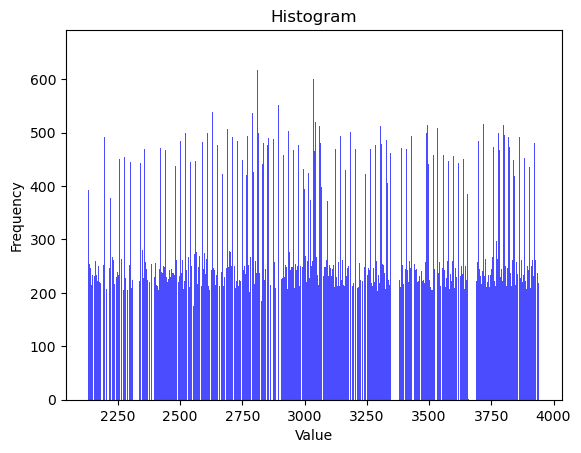

unique val: [2132.0 2133.0 2134.0 ... 3940.0 3941.0 3943.0]
unique ind: [217900 218021 218292 ... 301754 301972 302185]


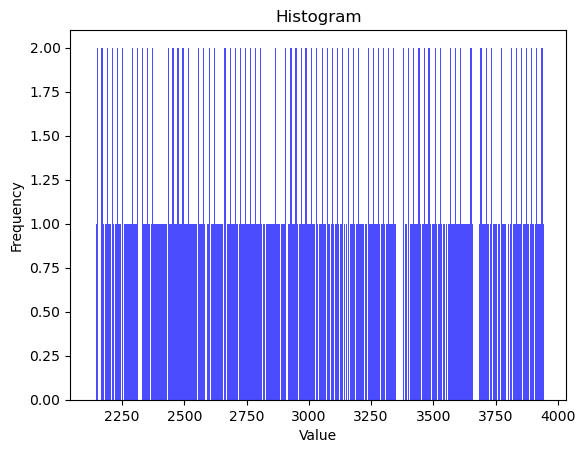

unique count [121 271 236 ... 218 213 183]
test:train ratio: 0.19958563535911603:0.800414364640884
len(sample_ind)/len(df): 0.0008330210705329605
sample ind [array([82879, 82880, 82881, 82882, 82883, 82884, 82885, 82886, 82887,
       82888, 82889, 82890, 82891, 82892, 82893, 82894, 82895, 82896,
       82897, 82898, 82899, 82900, 82901, 82902, 82903, 82904, 82905,
       82906, 82907, 82908, 82909, 82910, 82911, 82912, 82913, 82914,
       82915, 82916, 82917, 82918, 82919, 82920, 82921, 82922, 82923,
       82924, 82925, 82926, 82927, 82928, 82929, 82930, 82931, 82932,
       82933, 82934, 82935, 82936, 82937, 82938, 82939, 82940, 82941,
       82942, 82943, 82944, 82945, 82946, 82947, 82948, 82949, 82950,
       82951, 82952, 82953, 82954, 82955, 82956, 82957, 82958, 82959,
       82960, 82961, 82962, 82963, 82964, 82965, 82966, 82967, 82968,
       82969, 82970, 82971, 82972, 82973, 82974, 82975, 82976, 82977,
       82978, 82979, 82980, 82981, 82982, 82983, 82984, 82985, 82986,
  

In [34]:
def test_train_split_trials(config, df, y):
    
    
    trials = (np.vstack((df.index.get_level_values(0), df.index.get_level_values(1)))).transpose()
    
    renumber_trials(trials)
    
    train_size = config['train_test_split']['train_size']
    test_size = config['train_test_split']['test_size']
    
    print(train_size, test_size)
    
    print(trials[:, 1])
    hist(trials[:, 1])
    # should renumber trials, so duplicated trials arent grouped
    
    unique_values, unique_ind, unique_count = np.unique(trials[:, 1], return_index=True, return_counts=True)

    print(f"unique val: {unique_values}")
    print(f"unique ind: {unique_ind}")
    hist(unique_values)
    print(f"unique count {unique_count}")
    
    sample_size = int(test_size * len(unique_values))
    test_sample = np.random.choice(unique_values, size=sample_size, replace=False)
    # print(f"testsample: {test_sample}")
    
    print(f"test:train ratio: {len(test_sample) / len(unique_values)}:{(len(unique_values)-len(test_sample))/len(unique_values)}")
    
    sample_ind = []
    for sample in test_sample:
        sample_ind.append((np.where(df.index.get_level_values(1) == sample))[0])
    # do in boolean

    print(f"len(sample_ind)/len(df): {(len(sample_ind)/len(df))}")
    print(f"sample ind {sample_ind}")
    # X_test = df[test_sample, :]
    # X_train = df[~test_sample, :]
    # y_test = y[test_sample, :]
    # y_train = y[~test_sample, :]
    
    return 1, 1, 1, 1, 1 #X_train,X_test, y_train, y_test

# X_train,X_test, y_train, y_test = trial_split(config, df, temp)
test_list, X_train,X_test, y_train, y_test = test_train_split_trials(config, df_predictors_shift, temp)

# print('Training data has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))
# print('Testing data has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))


In [ ]:
# y_test1 = (y_test.values).flatten()
X_test.shape, y_test.shape

## Now, we're ready to run our GLM!

### We have two different options. If you know which params you would like to use, you can use the glm_fit.fit_glm function. If you would like tune your hyperparams to determine which are the best to use, you can use the glm_fit.fit_tuned_glm function. 

In [ ]:
# # Fit the model
model, y_pred, score, beta, intercept, sparse_beta = glm_fit.fit_glm(config, X_train, X_test, y_train, y_test)
print('Your model can account for {} percent of your data'.format(score*100))
modeltype = "fit"

In [ ]:
# Ridge Model:
model, y_pred, score, beta, intercept = glm_fit.fit_ridge(config, X_train, X_test, y_train, y_test)
print('Your model can account for {} percent of your data'.format(score*100))
modeltype = "fit"

In [ ]:
# Ridge Model CV:
tuned_model, y_pred, score, beta, best_params = glm_fit.fit_tuned_ridge(config, X_train, X_test, y_train, y_test)
print('Your model can account for {} percent of your data'.format(score*100))
modeltype = "tuned"

In [ ]:
shifts = config['glm_params']['predictors_shift_bounds']
# print(df.columns)
col_list = []
index = []
len_shift = 0
for col in df.columns:
    if 'z_grn' in col:
        continue
    else:
        col_list.append(col)
        # print(col)
        # print(shifts[col])
        head = shifts[col][0]
        tail = shifts[col][1]
        index.append(abs(head)+len_shift)
        len_shift = abs(head)+abs(tail)
        
dense_df = X_test.toarray()
test_pd = pd.DataFrame(dense_df[:, index], columns=col_list)
# test_pd.set_index(X_test.index)

In [ ]:
test_pd

In [ ]:
# np.where(test_pd['AAA_cue'] != df['AAA_cue'])
test_pd['AA_cue'].shape, df['AA_cue'].shape 


In [ ]:
# Fit the model with cross validation: remember, your alphas and l1_ratios should be lists
# tuned_model, y_pred, score, beta, best_params = glm_fit.fit_tuned_glm(config, X_train, X_test, y_train, y_test)
# print('Your model can account for {} percent of your data'.format(score*100))
# modeltype = 'tuned'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
def normalize(x, window):
    
    r = x.rolling(window=window,center=True)
    
    lower_bound = r.min()
    upper_bound = r.max()
    #lower_bound = r.quantile(0.05) # instead of .min()
    #upper_bound = r.quantile(0.95) # instead of .max()
    
    return (x-lower_bound)/(upper_bound-lower_bound)
  
def plot_spikes_with_prediction(df, spikes, predicted_spikes, dt,
                                nt=200, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    show (boolean): To plt.show or not the plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots(2, figsize=(12, 25))
  # lines = ax.stem(t, spikes[:nt])
  # plt.setp(lines, color=".5")
  
  i=0
  inc_height=1.2
  window_start = 10000 #10200 
  window_stop = 11000 #10500

  cols_to_plot = [col for col in df.columns]
  enl_columns = [col for col in df.columns if 'enl' in col]
  not_enl = [col for col in cols_to_plot if not any(enl_col in col for enl_col in enl_columns)]
  
  for j, col in enumerate(not_enl):
    if 'z_grn' in col:
      ax[0].plot((df[col].values*0.2)[window_start:window_stop] + i, label=col)
    else:
      ax[0].plot((df[col].values)[window_start:window_stop] + i, label=col)
    i += inc_height
    ax[0].text(x=1100, y=i - inc_height, s=col, fontsize=14, va="bottom")
  ax[0].set(
      # xlabel="Bins",
      ylabel="Events",
  )
    
  t = np.arange(0, len(spikes))*dt

  ax[1].plot(t[window_start:window_stop], spikes[window_start:window_stop], label='spikes')
  # lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax[1].plot(t[window_start:window_stop], predicted_spikes[window_start:window_stop], **kws, label='pred spikes')
  ax[1].set(
      xlabel="Bins",
      ylabel="Spikes",
  )
  ax[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax[1].axhline(y=0, color='grey', linestyle="--")
  # ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  ax[1].legend()
  

  plt.show()

fs = 1/48.440600198412696


# plot_spikes_with_prediction(y_test, y_pred, df.Timestamp[1] - df.Timestamp[0])
plot_spikes_with_prediction(df, y_test, y_pred, fs)


In [ ]:
print(y_test.shape, y_pred.shape)


In [ ]:
# best_params


acc:

## Save your outputs

In [ ]:
#Create your model dictonary, this should include all the information you wish to save
if modeltype == "fit":
    model_dict = {'model': model,
              'y_pred': y_pred,
              'score': score,
              'beta': beta,
              'intercept': intercept,
              'sparse_beta': sparse_beta,}
if modeltype == 'tuned':
    model_dict = {'model': tuned_model,
              'y_pred': y_pred,
              'score': score,
              'beta': beta,
              'best_params': best_params,}
    

#Save your model dictionary
model_path = project_path + '/models'
model_name = project_name + '_model.pkl'
model_full_path = os.path.join(model_path, model_name)
import pickle
with open(model_full_path, 'wb') as f:
    pickle.dump(model_dict, f)
        
# glm_fit.save_model(model_dict, project_path)

## Generate and save figures

In [ ]:
save_img = os.path.join(project_path)

glm_fit.plot_and_save(save_img, config, y_pred, y_test, beta, df_predictors_shift, format(score*100))

In [ ]:
combine_enl = True
if combine_enl:
    #save model fit results
    model_fit_results = pd.Series(beta, index=df_predictors_shift.columns, name='coef').unstack(0, )
    model_fit_results.index = model_fit_results.index.astype(int)
    model_fit_results = model_fit_results.reindex(config['glm_params']['predictors'], axis=1)

    # new added by liv for enl appending:
    if any('enl' in col for col in model_fit_results.columns):
        # could add sorting for enl precursors ie. history?
        enl_columns = [col for col in model_fit_results.columns if 'enl' in col]
        enl_col_df = model_fit_results[enl_columns]
        print(enl_col_df.shape)
        # for icol, col in enumerate(enl_col_df.columns):
            # print("col shape: " + col.shape)
            # print(f"col ind: {icol}")
            # print(f"col index pred shape: {enl_col_df.sort_index()[col]}")
        print("test - true: enl found")
            
        enl_all = np.array([])
        test = []
        for icol, col in enumerate(enl_col_df.columns):
            test.append(enl_col_df.sort_index()[col])
            nans = np.isnan(enl_col_df.sort_index()[col])
            enl_all = np.append(enl_all, enl_col_df.sort_index()[col][~nans])
            
        print(f"enl all shape: {enl_all.shape}")
        enl_df = pd.DataFrame({'enl': enl_all})
        
        test = np.where(enl_df['enl'] == 0)[0]
        model_test = model_fit_results.copy()
        # print(model_test.index)
        loc_insert = int((np.where(model_test.columns == enl_columns[0])[0])[0])
        print(loc_insert)
        
        model_test = model_test.sort_index()
        model_test = model_test.reindex(range(np.min(model_test.index), len(enl_all)))
        # print(model_test.shape)
        print(f"model test shape: {model_test.shape}")
            
        for col in enl_columns:
            # print(f"drop col: {str(col)}")
            model_test = model_test.drop(str(col), axis=1)

        # print(model_test.index)
        model_test = model_test.join(enl_df, how='left')
        col = model_test.pop('enl')
        model_test.insert(loc_insert, col.name, col)

        
        
    else:
        print("no enl found")

    ''' uncomment for comparison with and without joining enl:
    tup_y_lim = (np.inf, -np.inf)
    fig, axes = plt.subplots(1, len(model_fit_results.columns), figsize=(5*len(model_fit_results.columns), 5))
    axes = axes.flatten()
    for ipredictor, predictor in enumerate(model_fit_results.columns):
            
        axes[ipredictor].plot(model_fit_results.sort_index()[predictor])
        axes[ipredictor].set_title(predictor)
        axes[ipredictor].grid(True)
        
        tup_y_lim = (min(tup_y_lim[0], model_fit_results[predictor].min()-0.1),
                    max(tup_y_lim[1], model_fit_results[predictor].max()+0.1))

    for ax in axes:
        ax.set_ylim(tup_y_lim)
    fig.suptitle('GLM Coefficients Fit Results')
    '''
    ###########
    tup_y_lim = (np.inf, -np.inf)
    fig, axes = plt.subplots(1, len(model_test.columns), figsize=(5*len(model_test.columns), 5))
    axes = axes.flatten()
    for ipredictor, predictor in enumerate(model_test.columns):
        # print(f"predictor {predictor}")
            
        axes[ipredictor].plot(model_test.sort_index()[predictor])
        axes[ipredictor].set_title(predictor)
        axes[ipredictor].grid(True)
        
        tup_y_lim = (min(tup_y_lim[0], model_test[predictor].min()-0.1),
                    max(tup_y_lim[1], model_test[predictor].max()+0.1))

    for ax in axes:
        ax.set_ylim(tup_y_lim)
    fig.suptitle('GLM Coefficients Fit Results')
    plt.savefig(save_img + '/results/model_fit.png')
    print(f"saved to: {save_img + '/results/model_fit.png'}")
    plt.show()
    plt.close()